<a href="https://colab.research.google.com/github/siddhantkd/Bitoverflow_20/blob/master/A_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREREQUISITES**

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
from PIL import Image
from keras import backend, optimizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS_Siddhant.zip'

**DATA** **LOADER**

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = "/content/OUHANDS_Siddhant/training/colour"
maskpath = "/content/OUHANDS_Siddhant/training/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:02<00:00, 806.66it/s]


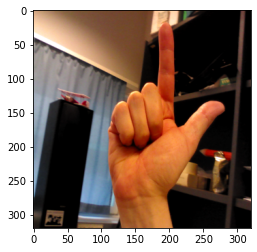

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [ ]:
def conv_block(x, filter_size, size, dropout=0.1, batch_norm=True):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [ ]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    
    model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = Attention_UNet(input_shape, 1, 0.1, True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

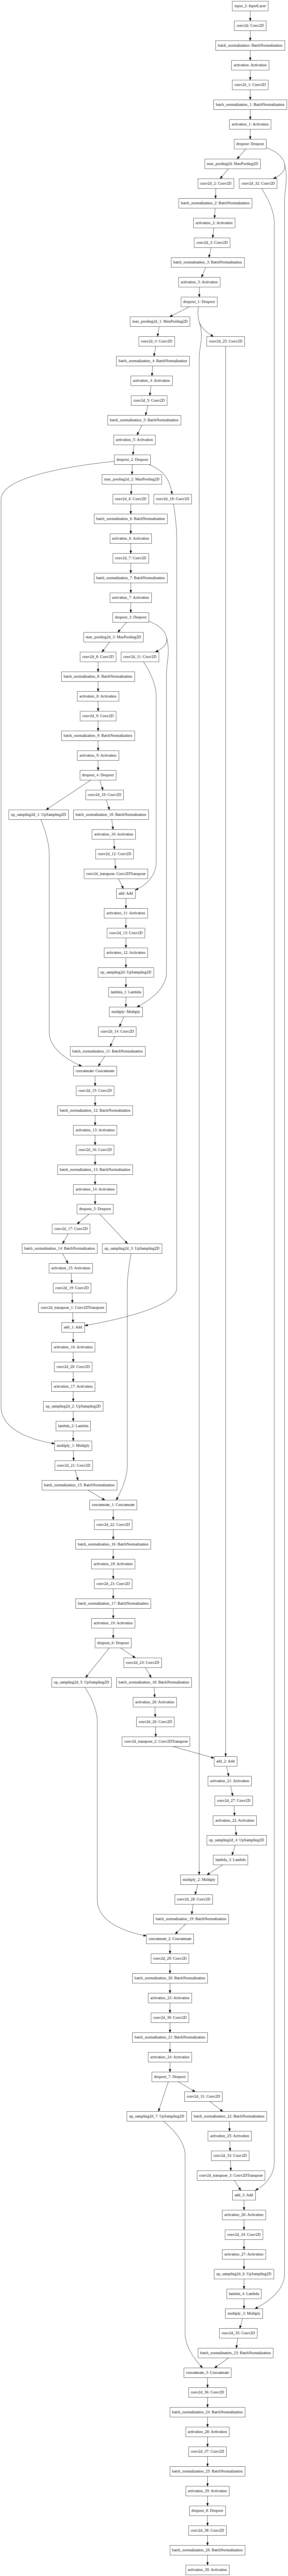

In [ ]:
#Our CNN model
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

##TRAINING

###10epochs

In [ ]:
#Model Checkpoint
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt"
model_checkpoint_AUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_AUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

TRAINED USING VALIDATION DATA AS SPLIT AND NOT TEST DATA

In [ ]:
history = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=2,epochs=10,callbacks=[model_checkpoint_AUNET])

Epoch 1/10
900/900 [==============================] - 188s 165ms/step - loss: 0.3820 - accuracy: 0.9494 - val_loss: 0.2514 - val_accuracy: 0.9667

Epoch 00001: val_accuracy improved from -inf to 0.96673, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt
Epoch 2/10
900/900 [==============================] - 147s 164ms/step - loss: 0.1915 - accuracy: 0.9753 - val_loss: 0.1432 - val_accuracy: 0.9778

Epoch 00002: val_accuracy improved from 0.96673 to 0.97782, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt
Epoch 3/10
900/900 [==============================] - 147s 164ms/step - loss: 0.1176 - accuracy: 0.9805 - val_loss: 0.0979 - val_accuracy: 0.9802

Epoch 00003: val_accuracy improved from 0.97782 to 0.98024, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt
Epoch 4/10
900/900 [==============================] - 147s 163ms/step - loss: 0.0837 - accuracy: 0.9818 - val_loss: 0.0766 - val_accurac

Text(0, 0.5, 'Training Error')

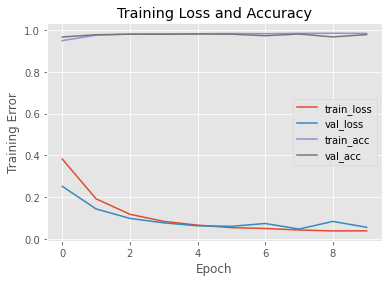

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

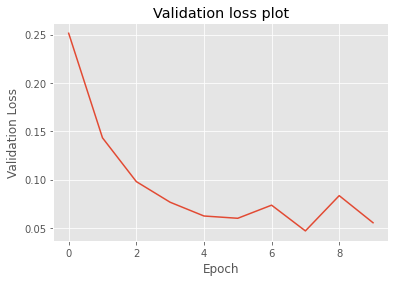

In [ ]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

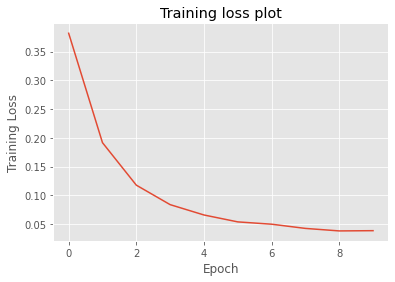

In [ ]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

###20epochs

In [ ]:
#Model Checkpoint
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/20epochs/cp.ckpt"
model_checkpoint_AUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_AUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h2 = model.fit(X_train,Y_train,validation_data=(X_test, Y_test),batch_size=2,epochs=10,callbacks=[model_checkpoint_AUNET])

Epoch 1/10
1000/1000 [==============================] - 199s 199ms/step - loss: 0.0416 - accuracy: 0.9834 - val_loss: 0.0932 - val_accuracy: 0.9663

Epoch 00001: val_accuracy improved from -inf to 0.96630, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/20epochs/cp.ckpt
Epoch 2/10
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0373 - accuracy: 0.9844 - val_loss: 0.1121 - val_accuracy: 0.9613

Epoch 00002: val_accuracy did not improve from 0.96630
Epoch 3/10
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0355 - accuracy: 0.9846 - val_loss: 0.1092 - val_accuracy: 0.9623

Epoch 00003: val_accuracy did not improve from 0.96630
Epoch 4/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0355 - accuracy: 0.9845 - val_loss: 0.0920 - val_accuracy: 0.9675

Epoch 00004: val_accuracy improved from 0.96630 to 0.96750, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/20epochs/cp.ckpt
Epoch 5/10
10

Text(0, 0.5, 'Training Error')

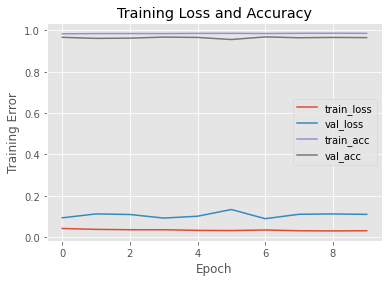

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

Text(0, 0.5, 'Validation Loss')

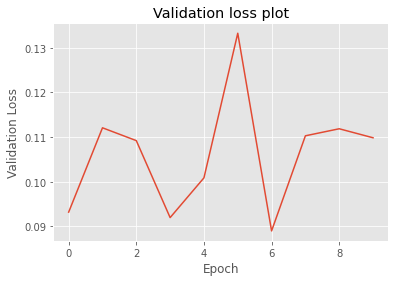

In [ ]:
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

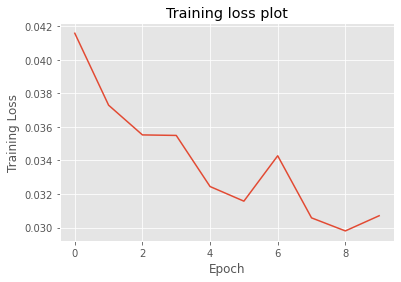

In [ ]:
plt.plot(np.arange(0,N), h2.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

###40

In [ ]:
#Model Checkpoint
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt"
model_checkpoint_AUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_AUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h2 = model.fit(X_train,Y_train,validation_data=(X_test, Y_test),batch_size=2,epochs=20,callbacks=[model_checkpoint_AUNET])

Epoch 1/20
1000/1000 [==============================] - 180s 180ms/step - loss: 0.0305 - accuracy: 0.9859 - val_loss: 0.1195 - val_accuracy: 0.9626

Epoch 00001: val_accuracy improved from -inf to 0.96257, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt
Epoch 2/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0318 - accuracy: 0.9853 - val_loss: 0.1290 - val_accuracy: 0.9559

Epoch 00002: val_accuracy did not improve from 0.96257
Epoch 3/20
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0301 - accuracy: 0.9859 - val_loss: 0.1230 - val_accuracy: 0.9630

Epoch 00003: val_accuracy improved from 0.96257 to 0.96302, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt
Epoch 4/20
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0293 - accuracy: 0.9862 - val_loss: 0.0840 - val_accuracy: 0.9686

Epoch 00004: val_accuracy improved from 0.96302 to 0.96863, saving m

Text(0, 0.5, 'Training Error')

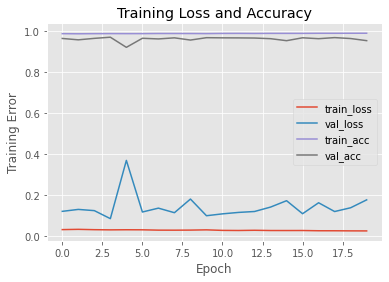

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

Text(0, 0.5, 'Validation Loss')

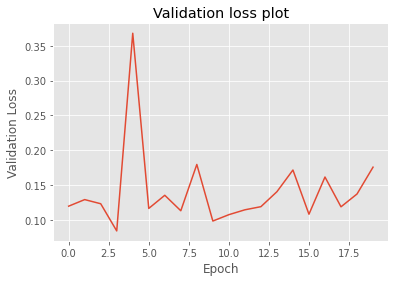

In [ ]:
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

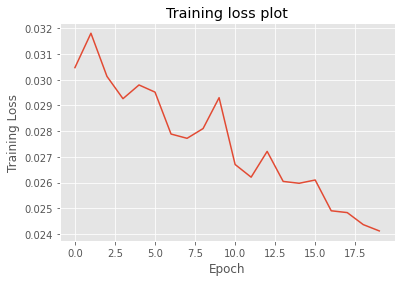

In [ ]:
plt.plot(np.arange(0,N), h2.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

###60 epochs

In [ ]:
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)

In [ ]:
#Model Checkpoint
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/60epochs/cp.ckpt"
model_checkpoint_AUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_AUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h2 = model.fit(X_train,Y_train,validation_data=(X_test, Y_test),batch_size=2,epochs=20,callbacks=[model_checkpoint_AUNET])

Epoch 1/20
1000/1000 [==============================] - 222s 183ms/step - loss: 0.0308 - accuracy: 0.9857 - val_loss: 0.1007 - val_accuracy: 0.9649

Epoch 00001: val_accuracy improved from -inf to 0.96492, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/60epochs/cp.ckpt
Epoch 2/20
1000/1000 [==============================] - 200s 200ms/step - loss: 0.0288 - accuracy: 0.9863 - val_loss: 0.1074 - val_accuracy: 0.9643

Epoch 00002: val_accuracy did not improve from 0.96492
Epoch 3/20
1000/1000 [==============================] - 200s 200ms/step - loss: 0.0281 - accuracy: 0.9866 - val_loss: 0.1095 - val_accuracy: 0.9646

Epoch 00003: val_accuracy did not improve from 0.96492
Epoch 4/20
1000/1000 [==============================] - 181s 181ms/step - loss: 0.0279 - accuracy: 0.9866 - val_loss: 0.1081 - val_accuracy: 0.9648

Epoch 00004: val_accuracy did not improve from 0.96492
Epoch 5/20
1000/1000 [==============================] - 200s 200ms/step - loss: 0.0275 - accuracy: 0

Text(0, 0.5, 'Training Error')

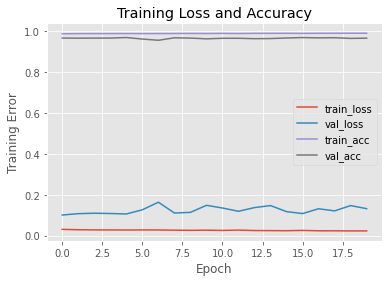

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

### 0 -60 epochs 

In [ ]:
#Model Checkpoint
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/0_60/cp.ckpt"
model_checkpoint_AUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_AUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=2,epochs=60,callbacks=[model_checkpoint_AUNET])

Epoch 1/60
900/900 [==============================] - 182s 159ms/step - loss: 0.3846 - accuracy: 0.9455 - val_loss: 0.2639 - val_accuracy: 0.9649

Epoch 00001: val_accuracy improved from -inf to 0.96488, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/0_60/cp.ckpt
Epoch 2/60
900/900 [==============================] - 144s 161ms/step - loss: 0.1927 - accuracy: 0.9751 - val_loss: 0.1543 - val_accuracy: 0.9734

Epoch 00002: val_accuracy improved from 0.96488 to 0.97339, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/0_60/cp.ckpt
Epoch 3/60
900/900 [==============================] - 143s 159ms/step - loss: 0.1175 - accuracy: 0.9807 - val_loss: 0.1115 - val_accuracy: 0.9743

Epoch 00003: val_accuracy improved from 0.97339 to 0.97430, saving model to /content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/0_60/cp.ckpt
Epoch 4/60
900/900 [==============================] - 143s 159ms/step - loss: 0.0837 - accuracy: 0.9820 - val_loss: 0.0733 - val_accuracy: 0.9815

E

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [ ]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

In [ ]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

##EVALUATION

In [ ]:
pred_train=model.predict(X_train[:int(X_train.shape[0])],verbose=1)

pred_train_t = (pred_train>0.5).astype(np.uint8)

ResourceExhaustedError: ignored

In [ ]:
for i in range(pred_train_t.shape[0]):
  name="seg"+str(i)+".jpg"
  img=np.reshape(pred_train_t[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
for i in range(pred_train_t.shape[0]):
  name="mask"+str(i)+".jpg"
  img=np.reshape(Y_train[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
!ls

archive  drive	sample_data


In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


##Test Data

In [ ]:
path = "/content/OUHANDS_Siddhant/testing/colour"
maskpath = "/content/OUHANDS_Siddhant/testing/segmentation"

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:01<00:00, 788.65it/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [ ]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

###10epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9645924999999999


Text(0.5, 1.0, 'TEST IMAGE')

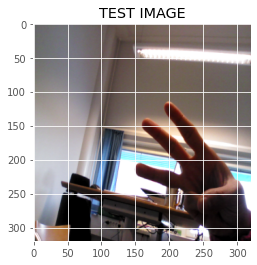

In [ ]:
plt.imshow(array_to_img(X_test[100]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

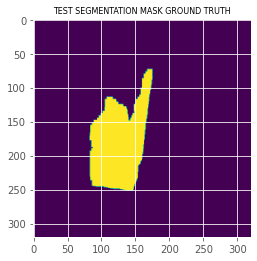

In [ ]:
plt.imshow(array_to_img(Y_test[200]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

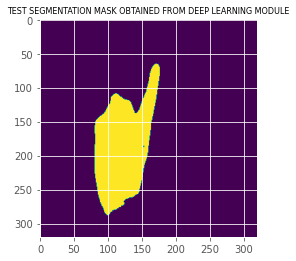

In [ ]:
plt.imshow(array_to_img(y_pred[200]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
x_test_single = np.expand_dims(X_test[7], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.9490256309509277 seconds ---


###20epochs

In [ ]:
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.967168330078125


In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/20epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9708054394531258


Text(0.5, 1.0, 'TEST IMAGE')

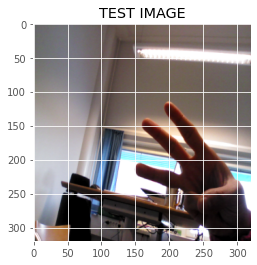

In [ ]:
plt.imshow(array_to_img(X_test[100]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

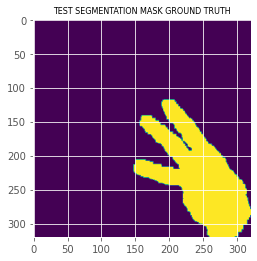

In [ ]:
plt.imshow(array_to_img(Y_test[100]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

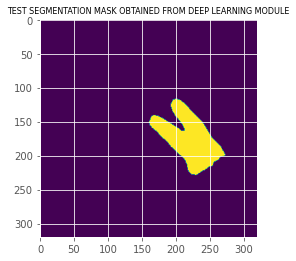

In [ ]:
plt.imshow(array_to_img(y_pred[100]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

##40epochs

In [ ]:
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.954823466796875


In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.970967216796876


Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

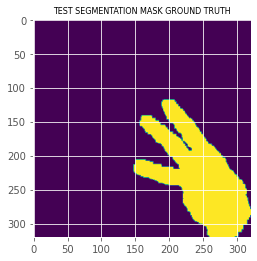

In [ ]:
plt.imshow(array_to_img(Y_test[100]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

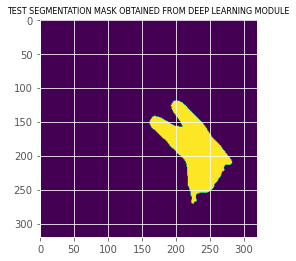

In [ ]:
plt.imshow(array_to_img(y_pred[100]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

## 60 epochs

In [ ]:
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9666900292968754


In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/60epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9699509863281256


Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

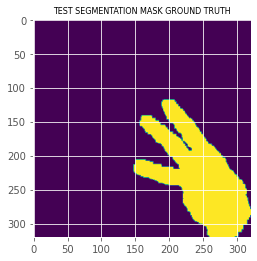

In [ ]:
plt.imshow(array_to_img(Y_test[100]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

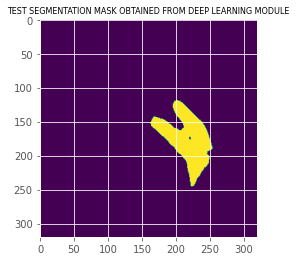

In [ ]:
plt.imshow(array_to_img(y_pred[100]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

##0-60 epochs val split

In [ ]:
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/0_60/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9669836132812514


Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

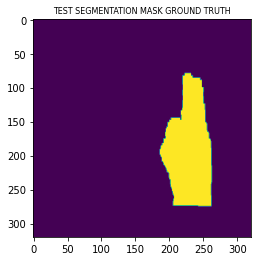

In [ ]:
plt.imshow(array_to_img(Y_test[23]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

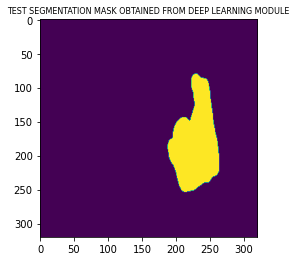

In [ ]:
plt.imshow(array_to_img(y_pred[23]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

# COMPILED

In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/10epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9645924999999999


In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/20epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9708054394531258


In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/40epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9709672070312492


Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

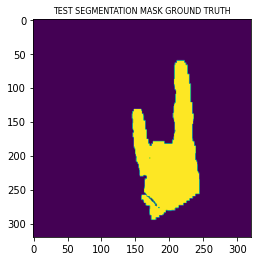

In [ ]:
plt.imshow(array_to_img(Y_test[1]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

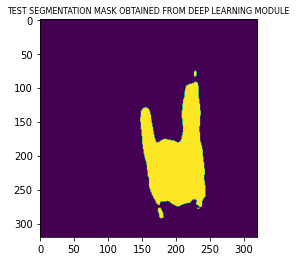

In [ ]:
plt.imshow(array_to_img(y_pred[1]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
 #    ######evaluate#####
checkpoint_path_AUNET = "/content/drive/MyDrive/A_UNET/V1/SEGMENTATION/_2/60epochs/cp.ckpt"
model.load_weights(checkpoint_path_AUNET)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9699509863281256
